# Truck 1: GPS Speed vs. Wheel-Based Speed

#### Imports and global variables are defined here.

In [9]:
# Imports required for this notebook.
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

# Local path to the CSV file containing the data for truck two (2).
truckOnePath = "../data/trucks/truck1.csv"

#### Functions are defined here.

In [2]:
"""Uses Pandas's read_csv method to read a CSV file and returns a DataFrame of it to the notebook.
This function reads in all rows and defines the header row at index 0 by default."""
def readCsv(truck, records = None, headerIdx = 0):
    return pd.read_csv(truck, nrows = records, header = [headerIdx])

##### GPS Speed vs. Wheel-Based Speed

Reading in the truck data; one can change how many records are read by using "records = <#>" in the readCsv function or remove it entirely to read all records.

In [3]:
truckOneDf = readCsv(truckOnePath)
truckOneDf.head()

,Time,1730_CH9_ AutomaticStartStop,1730_CH10_Truck_Batteries,4649_Ch1_Alternator_250A,4649_Ch2_BattOut_100A,4649_Ch3_Trailer_50A,4649_Ch4_Inverter_100A,4649_Ch5_Fridge_50A,4649_Ch6_200A_APU_BatteryBank,4649_Ch7_200A_BatterySeparator,...,WheelBasedVehicleSpeed,CPU load,UTC hour,UTC minute,UTC second,UTC month,UTC day,UTC year,GPS altitude,GPS speed
0,08/07/2019 07:54:02.959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.968750,40.0,11.0,54.0,3.0,8.0,7.0,19.0,0.0,NaN
1,08/07/2019 07:54:03.059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.042969,40.0,11.0,54.0,3.0,8.0,7.0,19.0,0.0,NaN
2,08/07/2019 07:54:03.159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.042969,40.0,11.0,54.0,3.0,8.0,7.0,19.0,0.0,NaN
3,08/07/2019 07:54:03.259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.105469,40.0,11.0,54.0,3.0,8.0,7.0,19.0,0.0,NaN
4,08/07/2019 07:54:03.359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.105469,40.0,11.0,54.0,3.0,8.0,7.0,19.0,0.0,NaN


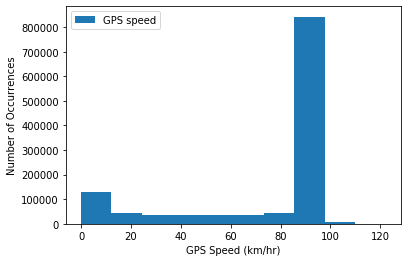

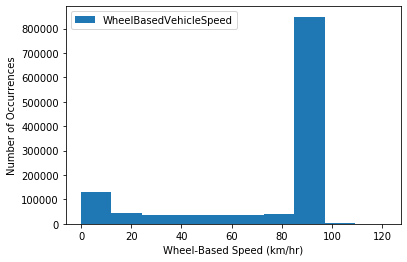

In [4]:
columns = ['GPS speed', 'WheelBasedVehicleSpeed']
gpsSpeedHist = truckOneDf[['GPS speed']].plot.hist(stacked=True)
gpsSpeedHist.set_xlabel('GPS Speed (km/hr)')
gpsSpeedHist.set_ylabel('Number of Occurrences')

wheelSpeedHist = truckOneDf[['WheelBasedVehicleSpeed']].plot.hist(stacked=True)
wheelSpeedHist.set_xlabel('Wheel-Based Speed (km/hr)')
wheelSpeedHist.set_ylabel('Number of Occurrences')

gpsSpeedHist
wheelSpeedHist

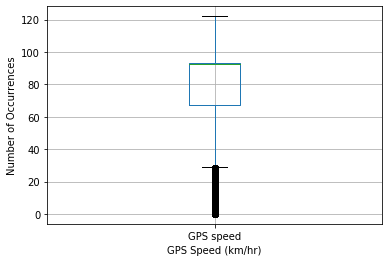

In [5]:
gpsSpeedBox = truckOneDf[['GPS speed']].boxplot()
gpsSpeedBox.set_xlabel('GPS Speed (km/hr)')
gpsSpeedBox.set_ylabel('Number of Occurrences')

gpsSpeedBox

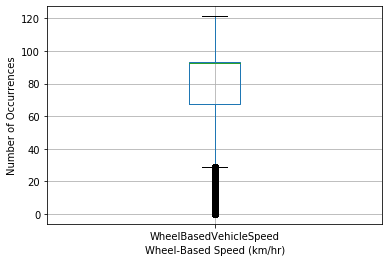

In [6]:
wheelSpeedBox = truckOneDf[['WheelBasedVehicleSpeed']].boxplot()
wheelSpeedBox.set_xlabel('Wheel-Based Speed (km/hr)')
wheelSpeedBox.set_ylabel('Number of Occurrences')

wheelSpeedBox

It's clear that both of these components have a similar trend; there is definitely a skewness to them. However, upon further inspection, the GPS Speed has a different scale on its x-axis. These are both supposed to be measured in km/hr.

It's possible that:
- The provided units for GPS Speed were incorrect.
- The GPS Speed unit is configured to a different unit of measurement (accidental or intentional).
  - Note: we have not yet found a conversion that matches the readings.
- The GPS Speed unit was incorrectly set up.

We can also see that there is a significant amount of readings near zero. We hypothesize that these values are from moments of inactivity, such as stopping at a light or leaving the truck on without moving. Outlier detection is currently being developed and will hopefully snuff these values out.

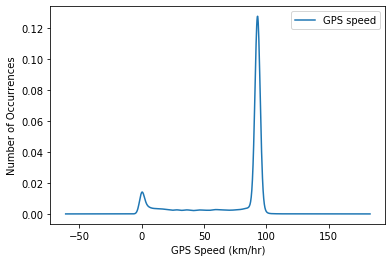

In [7]:
gpsSpeedDist = truckOneDf[['GPS speed']].plot.kde()
gpsSpeedDist.set_xlabel('GPS Speed (km/hr)')
gpsSpeedDist.set_ylabel('Number of Occurrences')

gpsSpeedDist

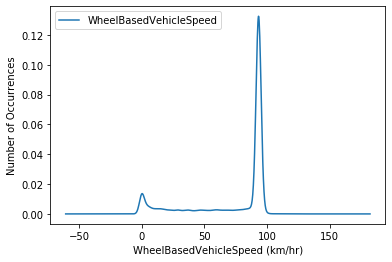

In [8]:
wheelSpeedDist = truckOneDf[['WheelBasedVehicleSpeed']].plot.kde()
wheelSpeedDist.set_xlabel('WheelBasedVehicleSpeed (km/hr)')
wheelSpeedDist.set_ylabel('Number of Occurrences')

wheelSpeedDist

At this point, since we haven't removed outliers or the movements of zero (stopped), there are two peaks which means that the raw data is bimodal. This would typically indicate that there are two groups within the data set; this data could technically have two groups: a stopped state and a moving state, where stopped represents all of the points near zero and the moving state represents all of the points near the right peak.